# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-rw-r-- 1 1000 1002 1.2K Feb  3 09:26 README.md


## Запуск spark

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "48g") \
    .config("spark.driver.memory", "48g") \
    .config("spark.local.dir", "/spark/") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [4]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [5]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [6]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [7]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [8]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [10]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [11]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [12]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [13]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=175727, mean_rating=5.0, ratings_count=1, movieId=175727, title='Cure for Pain: The Mark Sandman Story (2011)', genres='Documentary'),
 Row(movie_id=179685, mean_rating=5.0, ratings_count=1, movieId=179685, title='Keep My Grave Open (1976)', genres='Horror'),
 Row(movie_id=192415, mean_rating=5.0, ratings_count=1, movieId=192415, title='Last Hours in Suburbia (2012)', genres='Crime|Mystery|Thriller'),
 Row(movie_id=142160, mean_rating=5.0, ratings_count=1, movieId=142160, title='Carlos Spills the Beans (2014)', genres='Children|Comedy|Drama'),
 Row(movie_id=144208, mean_rating=5.0, ratings_count=1, movieId=144208, title='Bicycle Dreams (2009)', genres='Adventure|Documentary'),
 Row(movie_id=175083, mean_rating=5.0, ratings_count=1, movieId=175083, title='Look at Me (2012)', genres='Comedy|Drama|Romance'),
 Row(movie_id=139453, mean_rating=5.0, ratings_count=1, movieId=139453, title='Hide (2011)', genres='Horror'),
 Row(movie_id=173179, mean_rating=5.0, ratings_count=1, mo

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [14]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [15]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,356,81491,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,81482,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,79672,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,74127,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,72674,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,68717,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,64144,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,60411,527,Schindler's List (1993),Drama|War
8,110,59184,110,Braveheart (1995),Action|Drama|War
9,2959,58773,2959,Fight Club (1999),Action|Crime|Drama|Thriller


---
## SQL

In [16]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [17]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [18]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#131]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#134L, title#131]
+- Sort [count(1)#134L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#134L, first(title#31, false) AS title#131]
      +- Filter title#31 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#30 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#30,title#31,genres#32] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [19]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [20]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .sort(F.col('year').desc()) \
    .toPandas()

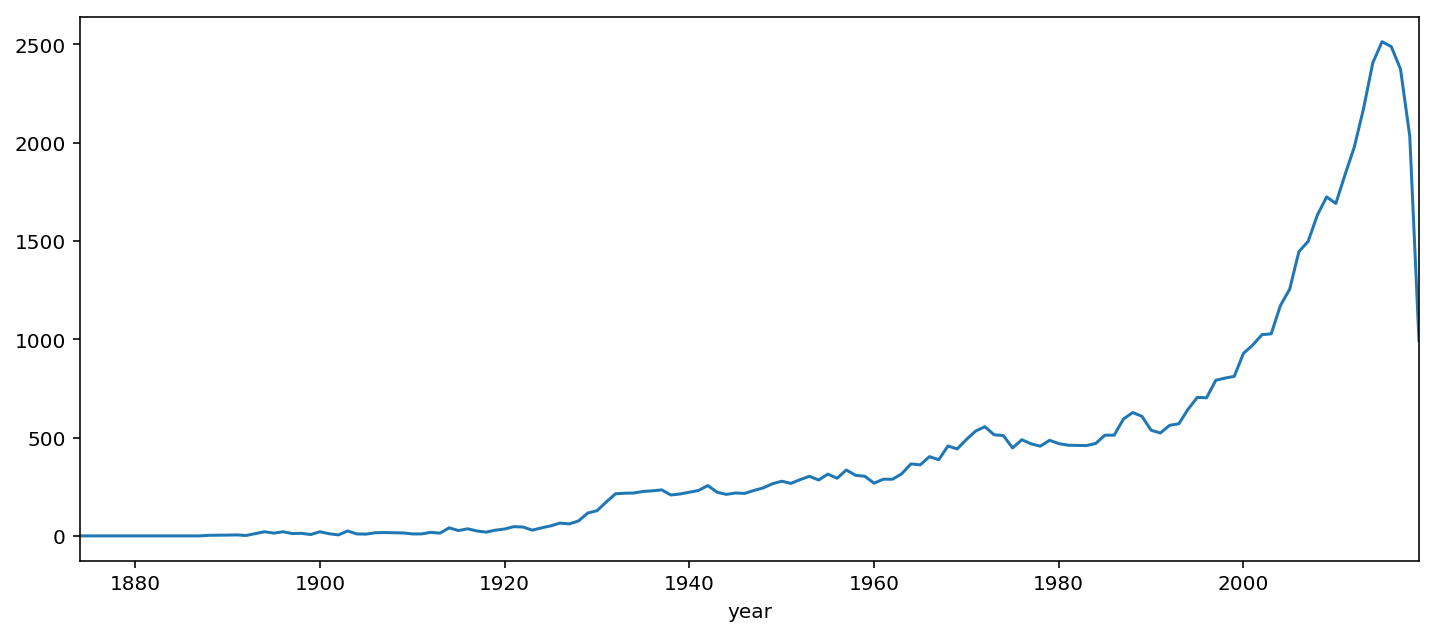

In [21]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [22]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

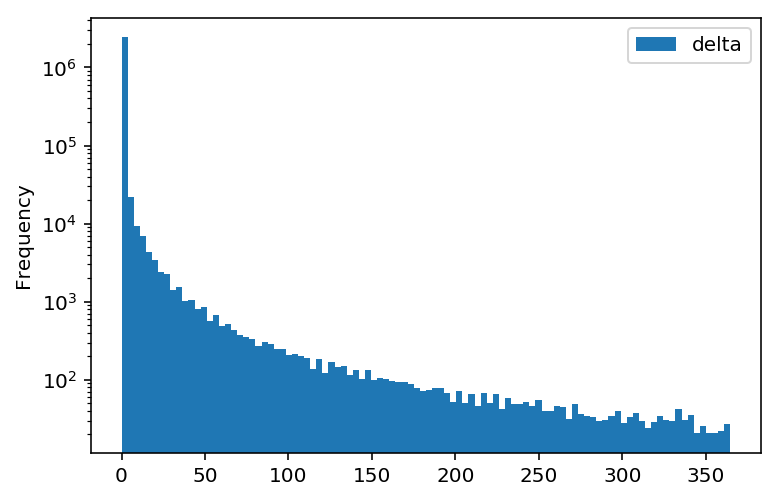

In [23]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [24]:
def get_movie_sim(ratings_df):
    movie_users_df = ratings_df \
        .groupby('movie_id') \
        .agg(F.count('user_id').alias('n_users')) \
        .cache()
        
    movie_movie_df = ratings_df.alias('r1') \
        .join(ratings_df.alias('r2'), F.col('r1.user_id') == F.col('r2.user_id')) \
        .groupby(F.col('r1.movie_id').alias('movie_id1'), F.col('r2.movie_id').alias('movie_id2')) \
        .agg(F.count('r1.user_id').alias('n_users')) \
        .cache()

    movie_movie_sim_df = movie_movie_df.alias('n0') \
        .join(movie_users_df.alias('n1'), movie_movie_df['movie_id1'] == F.col('n1.movie_id')) \
        .join(movie_users_df.alias('n2'), movie_movie_df['movie_id2'] == F.col('n2.movie_id')) \
        .select(
            'movie_id1',
            'movie_id2',
            (F.col('n0.n_users') / (F.col('n1.n_users') + F.col('n2.n_users') - F.col('n0.n_users'))).alias('sim')
        )
    
    return movie_movie_sim_df

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [25]:
from pyspark.sql.window import Window


def limit_df(df, n, col='user_id'):
    window = Window.partitionBy(col).orderBy(F.lit('A'))
    return df \
        .withColumn('rank', F.row_number().over(window)) \
        .filter(F.col('rank') <= n) \
        .drop('rank')

In [26]:
def remove_watched(suggest, ratings_df):
    return suggest \
        .join(ratings_df, on=['user_id', 'movie_id'], how='leftouter') \
        .filter(F.col('rating').isNull()) \
        .sort(F.col('sim').desc()) \
        .select('user_id', 'movie_id')

In [27]:
def pop(ratings_df, users_df, n):
    movie_users_df = ratings_df \
        .groupby('movie_id') \
        .agg(F.count('user_id').alias('sim'))
    
    suggest = users_df.crossJoin(movie_users_df)
    suggest = remove_watched(suggest, ratings_df)
    suggest = limit_df(suggest, n)
    
    return suggest

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [28]:
def user_based(ratings_df, users_df, n, alpha=0.9):
    movie_users_df = ratings_df \
        .groupby('movie_id') \
        .agg(F.count('user_id').alias('n_users')) \
        .cache()
    
    user_user_sim_df = ratings_df.alias('r1') \
        .join(users_df, on='user_id') \
        .join(ratings_df.alias('r2'), on='movie_id') \
        .groupby(
            F.col('r1.user_id').alias('user_id1'), 
            F.col('r2.user_id').alias('user_id2')
        ) \
        .agg(
            (
                F.sum(F.col('r1.rating') * F.col('r2.rating')) \
                / F.sqrt(F.sum(F.pow(F.col('r1.rating'), 2))) \
                / F.sqrt(F.sum(F.pow(F.col('r2.rating'), 2)))
            ).alias('sim')
        ) \
        .filter(F.col('sim') > alpha) \
        .cache()
    
    user_users_df = user_user_sim_df \
        .groupby(F.col('user_id1').alias('user_id')) \
        .agg(F.count('user_id2').alias('n_users'))
    
    movie_user_df = ratings_df \
        .join(user_user_sim_df, F.col('user_id') == F.col('user_id2')) \
        .groupby('movie_id', F.col('user_id1').alias('user_id')) \
        .agg(F.count('user_id2').alias('n_users'))
    
    suggest = movie_user_df.alias('n0') \
        .join(movie_users_df.alias('n1'), on='movie_id') \
        .join(user_users_df.alias('n2'), on='user_id') \
        .select(
            F.col('n0.user_id').alias('user_id'),
            F.col('n0.movie_id').alias('movie_id'),
            (F.col('n0.n_users') / (F.col('n1.n_users') + F.col('n2.n_users') - F.col('n0.n_users'))).alias('sim')
        )

    suggest = remove_watched(suggest, ratings_df)
    suggest = limit_df(suggest, n)
    
    return suggest

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [29]:
def item_knn(ratings_df, users_df, n):
    movie_movie_sim_df = get_movie_sim(ratings_df)

    suggest = ratings_df \
        .join(users_df, on='user_id') \
        .join(movie_movie_sim_df, ratings_df['movie_id'] == movie_movie_sim_df['movie_id1']) \
        .select(
            ratings_df['user_id'],
            movie_movie_sim_df['movie_id2'].alias('movie_id'),
            movie_movie_sim_df['sim']
        ) \
        .groupby('user_id', 'movie_id') \
        .agg(F.max('sim').alias('sim')) \
    
    suggest = remove_watched(suggest, ratings_df)
    suggest = limit_df(suggest, n)
    
    return suggest

## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [30]:
TRAIN = 0.8
TEST = 0.1
VALID = 1.0 - TRAIN - TEST

In [31]:
popular_movies_df = ratings_df \
    .groupby('movie_id') \
    .agg(F.count('user_id').alias('n_users')) \
    .sort(F.col('n_users').desc()) \
    .limit(1000) \
    .cache()

In [32]:
# Filter out not popular movies
ratings_df = ratings_df.join(popular_movies_df, on='movie_id')
ratings_df.count()

15117393

In [33]:
user_movies_df = ratings_df \
    .groupby('user_id') \
    .agg(F.count('movie_id').alias('n_movies')) \
    .cache()

active_users_df = user_movies_df \
    .filter(F.col('n_movies') > 200) \
    .select('user_id') \
    .cache()

active_users_df.count()

19192

In [34]:
# Filter out not active users
ratings_df = ratings_df.join(active_users_df, on='user_id')
ratings_df.count()

6350581

In [35]:
# Select users that have enough data in the valid dataset
users_df = active_users_df.limit(1000).cache()

In [36]:
time_window = Window.orderBy('timestamp').partitionBy('user_id')

rating_ratio_df = ratings_df \
    .join(user_movies_df, on='user_id') \
    .withColumn('ratio', F.row_number().over(time_window) / F.col('n_movies'))

train_ratings_df = rating_ratio_df \
    .filter(F.col('ratio') < TRAIN) \
    .drop('n_movies', 'ratio') \
    .cache()

valid_ratings_df = rating_ratio_df \
    .filter(F.col('ratio') >= TRAIN) \
    .filter(F.col('ratio') < TRAIN + VALID) \
    .drop('n_movies', 'ratio') \
    .cache()

test_ratings_df = rating_ratio_df \
    .filter(F.col('ratio') >= TRAIN + VALID) \
    .drop('n_movies', 'ratio')

In [37]:
# Test that all users have enough data in valid dataset
valid_ratings_df \
    .join(users_df, on='user_id') \
    .groupby('user_id') \
    .agg(F.count('*').alias('n_movies')) \
    .filter(F.col('n_movies') >= 10) \
    .count()

1000

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $$Map@N$$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [38]:
def get_precision(true_df, pred_df):
    precision = pred_df \
        .join(true_df,  on=['user_id', 'movie_id'], how='leftouter') \
        .select(F.mean(F.col('rating').isNotNull().cast('int')).alias('precision')) \
        .take(1)[0].precision
    
    return precision if precision else 0.0

In [39]:
def get_recall(true_df, pred_df):
    true_user_movies_df = true_df\
        .groupby('user_id') \
        .agg(F.count('movie_id').alias('n_true_movies'))
    
    pred_user_movies_df = pred_df \
        .join(true_df, on=['user_id', 'movie_id'], how='leftouter') \
        .withColumn('rel', F.col('rating').isNotNull().cast('int')) \
        .groupby(pred_df['user_id']) \
        .agg(F.sum('rel').alias('n_pred_movies'))
    
    recall = pred_user_movies_df \
        .join(true_user_movies_df, on='user_id') \
        .select(F.mean(F.col('n_pred_movies') / F.col('n_true_movies')).alias('recall')) \
        .take(1)[0].recall
    
    return recall if recall else 0.0

In [40]:
def get_map(true_df, pred_df):
    window = Window.partitionBy('user_id').orderBy(F.lit('A'))
    window_rel = Window.partitionBy('user_id').orderBy('rank')
    
    map_ = pred_df \
        .join(true_df, on=['user_id', 'movie_id'], how='leftouter') \
        .withColumn('rank', F.row_number().over(window)) \
        .withColumn('rel', F.col('rating').isNotNull().cast('int')) \
        .withColumn('ap', F.sum('rel').over(window_rel)) \
        .select((F.mean(F.col('rel') * F.col('ap') / F.col('rank'))).alias('map')) \
        .take(1)[0].map

    return map_ if map_ else 0.0

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [41]:
def metrics(true_df, pred_df, ns=[10, 5, 1]):
    for n in ns:
        # Select top n recommendations
        pred_df = limit_df(pred_df, n)
        
        precisoin = get_precision(true_df, pred_df)
        recall = get_recall(true_df, pred_df)
        map_ = get_map(true_df, pred_df)
        
        print('Precision@{}: {:.4f}'.format(n, precisoin))
        print('Recall@{}: {:.4f}'.format(n, recall))
        print('MAP@{}: {:.4f}\n'.format(n, map_))

### POP

In [46]:
pred_df = pop(train_ratings_df, users_df, 10)

In [47]:
metrics(valid_ratings_df, pred_df)

Precision@10: 0.1630
Recall@10: 0.0502
MAP@10: 0.0813

Precision@5: 0.1800
Recall@5: 0.0279
MAP@5: 0.1124

Precision@1: 0.1990
Recall@1: 0.0063
MAP@1: 0.1990



### User-based Collaborative Filtering¶

In [42]:
pred_df = user_based(train_ratings_df, users_df, 10)

In [43]:
metrics(valid_ratings_df, pred_df)

Precision@10: 0.1631
Recall@10: 0.0503
MAP@10: 0.0806

Precision@5: 0.1814
Recall@5: 0.0282
MAP@5: 0.1145

Precision@1: 0.1960
Recall@1: 0.0063
MAP@1: 0.1960



### Item-kNN

In [44]:
pred_df = item_knn(train_ratings_df, users_df, 10)

In [45]:
metrics(valid_ratings_df, pred_df)

Precision@10: 0.1802
Recall@10: 0.0550
MAP@10: 0.0895

Precision@5: 0.1930
Recall@5: 0.0297
MAP@5: 0.1218

Precision@1: 0.2330
Recall@1: 0.0073
MAP@1: 0.2330

